# Importing Modules and Reading Data

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import fancyimpute
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler 
import imblearn.ensemble
imblearn.ensemble.EasyEnsembleClassifier()
from sklearn.ensemble import BaggingClassifier
from mlens.visualization import corrmat
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from keras import models, layers, optimizers


from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from imblearn.ensemble import BalancedBaggingClassifier

from fancyimpute import IterativeImputer as MICE
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

[MLENS] backend: threading


In [4]:
df = pd.read_csv("./loan_data.csv")
print(f"\033[1m\033[94mData types:\n{11 * '-'}") 
print(f"\033[30m{df.dtypes}\n")
print(f"\033[1m\033[94mSum of null values in each feature:\n{35 * '-'}")
print(f"\033[30m{df.isnull().sum()}")
df.head() 

Data types:
-----------
credit.policy          int64
purpose               object
int.rate             float64
installment          float64
log.annual.inc       float64
dti                  float64
fico                   int64
days.with.cr.line    float64
revol.bal              int64
revol.util           float64
inq.last.6mths         int64
delinq.2yrs            int64
pub.rec                int64
not.fully.paid         int64
dtype: object

Sum of null values in each feature:
-----------------------------------
credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


Positive examples = 1533
Negative examples = 8045
Proportion of positive to negative examples = 19.06%


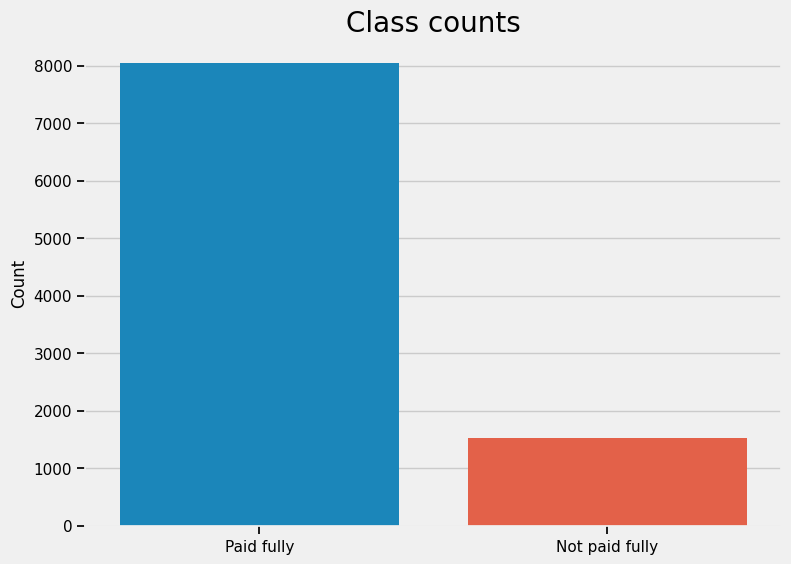

In [12]:
pos = df[df["not.fully.paid"] == 1].shape[0]
neg = df[df["not.fully.paid"] == 0].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")
plt.figure(figsize=(8, 6))
sns.countplot(x ='not.fully.paid', data = df)
plt.xticks((0, 1), ["Paid fully", "Not paid fully"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});

# Data Modeling

In [6]:
df = pd.get_dummies(df, columns=["purpose"], drop_first=True) 
df.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


In [7]:
for feature in df.columns:
    if np.any(pd.isnull(df[feature])):
        df["is_" + feature + "_missing"] = pd.isnull(df[feature]) * 1

df.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


### MICE - Multiple Imputation by chained Equations

Fill the missing data with MICE value

1. Impute Missing Values
2. Linear Regression for all features and filling the missing values using Linear Regression
3. Repeat

In [8]:
X = df.loc[:, df.columns != "not.fully.paid"].values
y = df.loc[:, df.columns == "not.fully.paid"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

mice = MICE(verbose=0)
X_mice = mice.fit_transform(X)
X_train_mice, X_test_mice, y_train_mice, y_test_mice = train_test_split(
    X_mice, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"MICE data shapes: {X_train_mice.shape, X_test_mice.shape}")

Original data shapes: ((7662, 18), (1916, 18))
MICE data shapes: ((7662, 18), (1916, 18))


### Random Forest

- Contains N decision tree on vairous subset to improve predictive accuracy by ensembling methods
- Split training data into multiple subsets apply decision tree on each subset and combine them to get result

1. Select k random points
2. Build decision tree from each selected points
3. Choose N decision trees to build
4. Repete the tesps 2 and 3
5. find prediction for all decision trees

# Bulding Random Forst Classifier

In [16]:
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")

pip_baseline = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_baseline,
                         X_train_dropna, y_train_dropna,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mBaseline model's average AUC: {scores.mean():.3f}")

pip_impute_mean = make_pipeline(SimpleImputer(strategy="mean"),
                                RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_mean,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mMean imputation model's average AUC: {scores.mean():.3f}")

pip_impute_median = make_pipeline(SimpleImputer(strategy="median"),
                                  RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_median,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mMedian imputation model's average AUC: {scores.mean():.3f}")

pip_impute_mice = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_mice,
                         X_train_mice, y_train_mice,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mMICE imputation model's average AUC: {scores.mean():.3f}")

Baseline model's average AUC: 0.643
Mean imputation model's average AUC: 0.653
Median imputation model's average AUC: 0.656
MICE imputation model's average AUC: 0.651


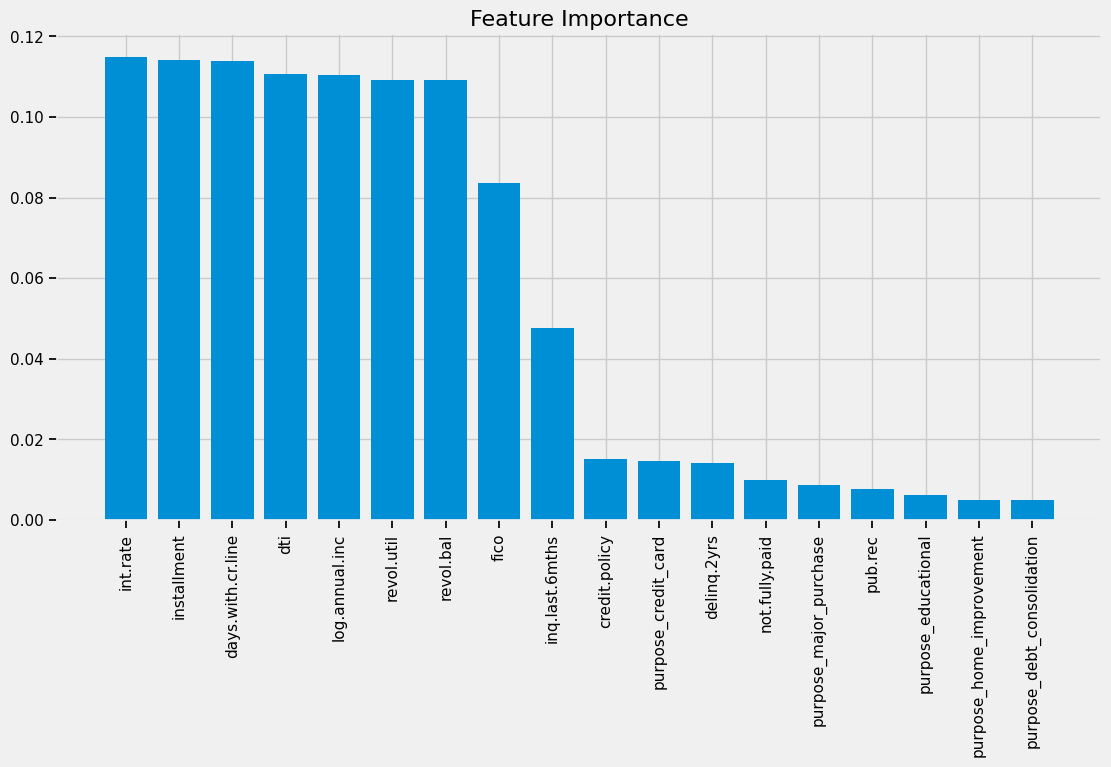

In [17]:
rf_clf.fit(RobustScaler().fit_transform(SimpleImputer(strategy="median").fit_transform(X_train)), y_train)

importances = rf_clf.feature_importances_
indices = np.argsort(rf_clf.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, 19), importances[indices], align="center")
plt.xticks(range(1, 19), df.columns[df.columns != "not_fully_paid"][indices], rotation=90)
plt.title("Feature Importance", {"fontsize": 16});

In [18]:
X_train = X_train[:, :-6]
X_test = X_test[:, :-6]

### Under Sampling
    Under-sample the majority class with or w/o replacement by making the number of positive and negative examples equal. One of the drawbacks of under-sampling is that it ignores a good portion of training data that has valuable information. In our example, it would loose around 6500 examples. However, it’s very fast to train.
### Over Sampling
    Over-sample the minority class with or w/o replacement by making the number of positive and negative examples equal. We’ll add around 6500 samples from the training data set with this strategy. It’s a lot more computationally expensive than under-sampling. Also, it’s more prune to overfitting due to repeated examples.
### Easy Ensembling
    Sample several subsets from the majority class, build a classifier on top of each sampled data, and combine the output of all classifiers. More details can be found here.
### SMOT
    Synthetic Minority Oversampling Technique (SMOTE): It over-samples the minority class but using synthesized examples. It operates on feature space not the data space. Here how it works:
1. Compute the k-nearest neighbors for all minority samples.
2. Randomly choose number between 1-k.
3. For each feature:  

a. Compute the difference between minority sample and its randomly chosen neighbor (from previous step).

b. Multiply the difference by random number between 0 and 1.

c. Add the obtained feature to the synthesized sample attributes.

4. Repeat the above until we get the number of synthesized samples needed. More information can be found here.

# Dealing with Imbalanced Data

In [19]:
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")

pip_orig = make_pipeline(SimpleImputer(strategy="mean"),
                         RobustScaler(),
                         rf_clf)
scores = cross_val_score(pip_orig,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mOriginal model's average AUC: {scores.mean():.3f}")

pip_undersample = imb_make_pipeline(SimpleImputer(strategy="mean"),
                                    RobustScaler(),
                                    RandomUnderSampler(), rf_clf)
scores = cross_val_score(pip_undersample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mUnder-sampled model's average AUC: {scores.mean():.3f}")

pip_oversample = imb_make_pipeline(SimpleImputer(strategy="mean"),
                                    RobustScaler(),
                                    RandomOverSampler(), rf_clf)
scores = cross_val_score(pip_oversample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mOver-sampled model's average AUC: {scores.mean():.3f}")

resampled_rf = BalancedBaggingClassifier(base_estimator=rf_clf,
                                         n_estimators=10, random_state=123)
pip_resampled = make_pipeline(SimpleImputer(strategy="mean"),
                              RobustScaler(), resampled_rf)
                             
scores = cross_val_score(pip_resampled,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mEasyEnsemble model's average AUC: {scores.mean():.3f}")

pip_smote = imb_make_pipeline(SimpleImputer(strategy="mean"),
                              RobustScaler(),
                              SMOTE(), rf_clf)
scores = cross_val_score(pip_smote,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mSMOTE model's average AUC: {scores.mean():.3f}")

Original model's average AUC: 0.640
Under-sampled model's average AUC: 0.632
Over-sampled model's average AUC: 0.637
EasyEnsemble model's average AUC: 0.654
SMOTE model's average AUC: 0.637


# Using Ensembleing Methods 

In [20]:
imp = SimpleImputer()

imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

std = RobustScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

random_undersampler = RandomUnderSampler()
X_res, y_res = random_undersampler.fit_resample(X_train, y_train)
3
perms = np.random.permutation(X_res.shape[0])
X_res = X_res[perms]
y_res = y_res[perms]
X_res.shape, y_res.shape

((2452, 12), (2452,))

#  Receiver Operating Characteristics (ROC) and Precision-Recall (PR) Curves

## XGB Classifier
    Each Predictor corrects it's predecessor's Error

1. Assign weights to all the independent variables
2. Weight of variable which did not get predected are incresed
3. New weights are fed to new decission tree
4. Ensemble to get a Strong Model

## Support Vector Machine 
    Create best DEcision boundry to segrate into classes to get new data points in correct category 

- Consider Points in a 2D space
- 2 types of points with 2 different features
- We Draw a line to separate the points into 2 groups
- SVM algorothem find the best line(Decison Boundry) called as hyperplane

1. consider one more plane in z axis
2. z = x^2 + y^2
3. from a plane parallel to x-axis with z = r
4. Get a circle with radius r


## Logistic Regression
    Supervised Learning Techinque to Predicit categorical dependend variable using given independent variables
    
    Logistic Regression predits the dependent variables using independent variables. Used to solve the classificationproblems. We Fit a S shaped logistic curve
    
#### Logistic Function
- The sigmoid function is used to map predicted values to probabilities
- Map any real values to another value withing range of 0 and 1
- The value above threshold value is 1 and below will tend to 0
#### Logistic Regression Equation
1. y = b0 + bixi + b2x2 + b3x3
2. y/1-y for y = 0 and y = 1
3. log(y/1-y0 = b0 + bixi + b2x2 + b3x3 ...


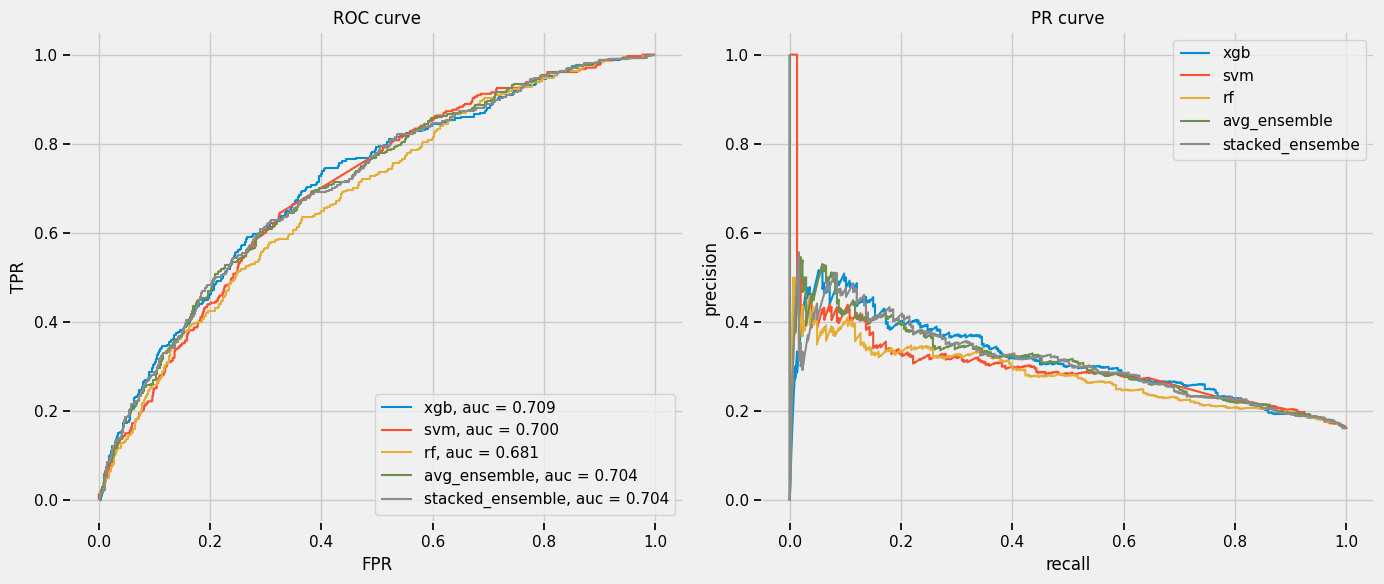

In [21]:
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                            learning_rate=0.03,
                            n_estimators=500,
                            max_depth=1,
                            subsample=0.4,
                            random_state=123)

svm_clf = SVC(gamma=0.1,
                C=0.01,
                kernel="poly",
                degree=3,
                coef0=10.0,
                probability=True)

rf_clf = RandomForestClassifier(n_estimators=300,
                                max_features="sqrt",
                                criterion="gini",
                                min_samples_leaf=5,
                                class_weight="balanced")

logreg_clf = LogisticRegression(penalty="l2",
                                C=100,
                                fit_intercept=True)

voting_clf = VotingClassifier([("xgb", xgb_clf),
                               ("svm", svm_clf),
                               ("rf", rf_clf)],
                              voting="soft",
                              flatten_transform=True)
voting_clf.fit(X_res, y_res)
xgb_model, svm_model, rf_model = voting_clf.estimators_
models = {"xgb": xgb_model, "svm": svm_model,
          "rf": rf_model, "avg_ensemble": voting_clf}

first_stack = make_pipeline(voting_clf,
                            FunctionTransformer(lambda X: X[:, 1::2]))

meta_features = cross_val_predict(first_stack,
                                  X_res, y_res,
                                  cv=10,
                                  method="transform")

first_stack.fit(X_res, y_res)

second_stack = logreg_clf.fit(meta_features, y_res)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for name, model in models.items():
            model_probs = model.predict_proba(X_test)[:, 1:]
            model_auc_score = roc_auc_score(y_test, model_probs)
            fpr, tpr, _ = roc_curve(y_test, model_probs)
            precision, recall, _ = precision_recall_curve(y_test, model_probs)
            axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
            axes[1].plot(recall, precision, label=f"{name}")
stacked_probs = second_stack.predict_proba(first_stack.transform(X_test))[:, 1:]
stacked_auc_score = roc_auc_score(y_test, stacked_probs)
fpr, tpr, _ = roc_curve(y_test, stacked_probs)
precision, recall, _ = precision_recall_curve(y_test, stacked_probs)
axes[0].plot(fpr, tpr, label=f"stacked_ensemble, auc = {stacked_auc_score:.3f}")
axes[1].plot(recall, precision, label="stacked_ensembe")
axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()

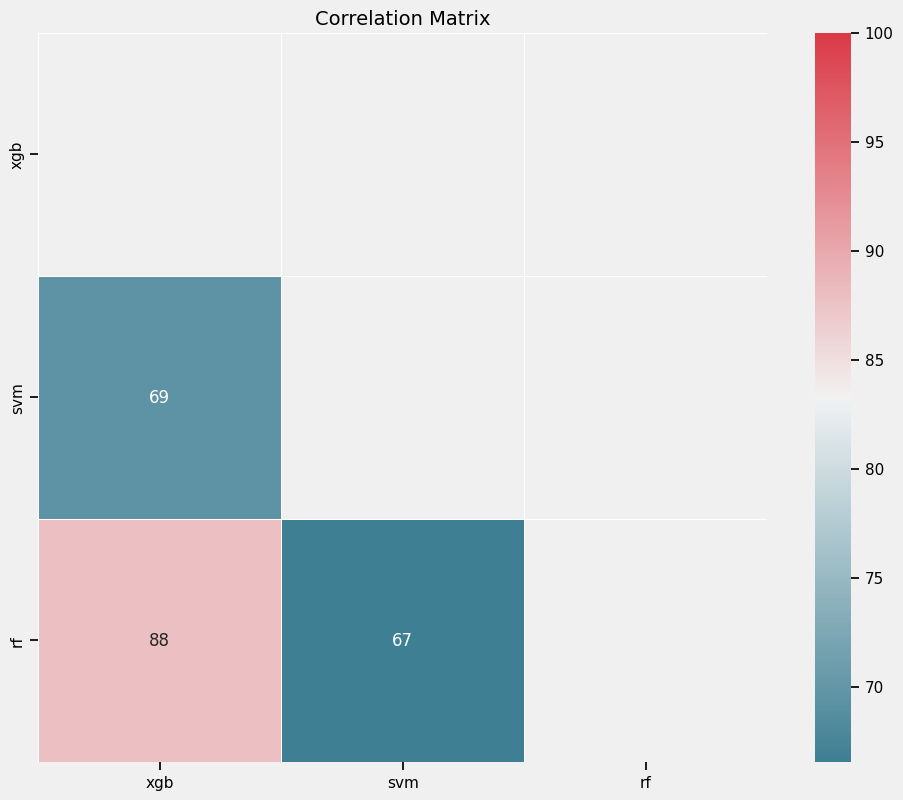

In [22]:
import pandas as pd   

from pymfe.mfe import MFE
probs_df = pd.DataFrame(meta_features, columns=["xgb", "svm", "rf"]) 
corrmat(probs_df.corr(), inflate=True);

<Figure size 1600x800 with 0 Axes>

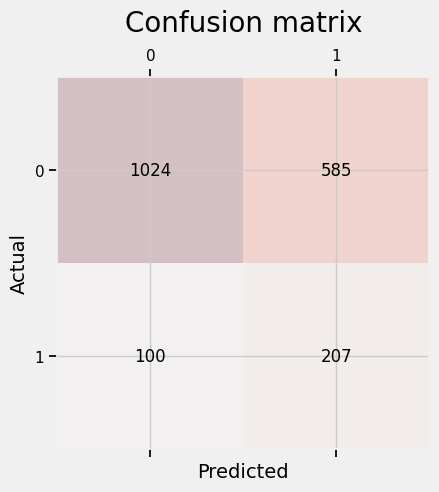

In [23]:
second_stack_probs = second_stack.predict_proba(first_stack.transform(X_test))
second_stack_preds = second_stack.predict(first_stack.transform(X_test))
conf_mat = confusion_matrix(y_test, second_stack_preds)

plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
  for j in range(2):
    plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});